# STAGE III - REAL WORLD OPTIMIZATION

![FIGURE](STAGE-III.png)

## DEPENDENCIES

In [1]:
# COMMON
import numpy as np
import sys
import os
import random
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Triggering Mechanism
import triggering as trig

# Signal Processing
from scipy import signal  # for signal processing
from scipy.signal import hilbert  # for signal processing
import prenn # for deep learning

# AI
import keras

import tensorflow as tf # for deep learning
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import TensorBoard # for visualization

import onnxruntime as ort # for onnx runtime

# Visualization
# %matplotlib qt5
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

## CLOSED-LOOP CONTROL COMPONENTS SETUP

### ENVIRONMENT

IN NATURE - THE SYNTHESIZED RESPONSE DATA - DIFFERENT FROM STAGE II

In [2]:
# Corrected Paths
AVPath = r'../01-PRE-DEPLOYMENT/DATA/VAL_RES/VAL_DATA_AV.npy' 
EQPath = r'../01-PRE-DEPLOYMENT/DATA/VAL_RES/VAL_DATA_EQ.npy'
IPPath = r'../01-PRE-DEPLOYMENT/DATA/VAL_RES/VAL_DATA_IP.npy'
SWPath = r'../01-PRE-DEPLOYMENT/DATA/VAL_RES/VAL_DATA_SW.npy'

# Load Data
RESPONSE_AV = np.load(AVPath)
RESPONSE_EQ = np.load(EQPath)
RESPONSE_IP = np.load(IPPath)
RESPONSE_SW = np.load(SWPath)

## only use part of the data
raw_len_av = RESPONSE_AV.shape[0]
raw_len_eq = RESPONSE_EQ.shape[0]
raw_len_ip = RESPONSE_IP.shape[0]
raw_len_sw = RESPONSE_SW.shape[0]

# this is to simulate the imbalanced data - ensure the same ratio within STAGE III
ratio_aw = 0.6
ratio_eq = 1
ratio_ip = 1
ratio_sw = 1

uselen_aw = int(raw_len_av * ratio_aw)
uselen_eq = int(raw_len_eq * ratio_eq)  
uselen_ip = int(raw_len_ip * ratio_ip)
uselen_sw = int(raw_len_sw * ratio_sw)

# randomly pick uselen_aw samples from RESPONSE_XX, no repeat
idx_aw = random.sample(range(raw_len_av), uselen_aw)
idx_eq = random.sample(range(raw_len_eq), uselen_eq)
idx_ip = random.sample(range(raw_len_ip), uselen_ip)
idx_sw = random.sample(range(raw_len_sw), uselen_sw)

RESPONSE_AV = RESPONSE_AV[idx_aw]
RESPONSE_EQ = RESPONSE_EQ[idx_eq]
RESPONSE_IP = RESPONSE_IP[idx_ip]
RESPONSE_SW = RESPONSE_SW[idx_sw]

## Check Data Info
print(type(RESPONSE_AV))
print('RESPONSE_AV Shape:', RESPONSE_AV.shape)
print(type(RESPONSE_EQ))
print('RESPONSE_EQ Shape:', RESPONSE_EQ.shape)
print(type(RESPONSE_IP))
print('RESPONSE_IP Shape:', RESPONSE_IP.shape)
print(type(RESPONSE_SW))
print('RESPONSE_SW Shape:', RESPONSE_SW.shape)

num_type = 4

signal_length = RESPONSE_AV.shape[1]

LenTS = signal_length

# ratio of non-interested data to interested data
ratio_ni = RESPONSE_AV.shape[0] / (RESPONSE_EQ.shape[0] + RESPONSE_IP.shape[0] + RESPONSE_SW.shape[0])

print('Ratio of Non-Interested Data to Interested Data:', ratio_ni)

## Stack Data
RESPONSE = np.vstack((RESPONSE_AV, RESPONSE_EQ, RESPONSE_IP, RESPONSE_SW))

## Total Number of Samples
NumSample = RESPONSE.shape[0]
print('Total Number of Samples:', NumSample) 

<class 'numpy.ndarray'>
RESPONSE_AV Shape: (150, 6000)
<class 'numpy.ndarray'>
RESPONSE_EQ Shape: (50, 6000)
<class 'numpy.ndarray'>
RESPONSE_IP Shape: (50, 6000)
<class 'numpy.ndarray'>
RESPONSE_SW Shape: (50, 6000)
Ratio of Non-Interested Data to Interested Data: 1.0
Total Number of Samples: 300


In [3]:
NUM_AV = RESPONSE_AV.shape[0]
NUM_EQ = RESPONSE_EQ.shape[0]
NUM_IP = RESPONSE_IP.shape[0]
NUM_SW = RESPONSE_SW.shape[0]

#print
print('Number of AV:', NUM_AV)
print('Number of EQ:', NUM_EQ)
print('Number of IP:', NUM_IP)
print('Number of SW:', NUM_SW)

Number of AV: 150
Number of EQ: 50
Number of IP: 50
Number of SW: 50


### SYSTEM
IN NATURE - THE TRIGGERING MECHANISM

In [4]:
# embodied in the triggering.py

In [5]:
# determine the search space by check the maximum and minimum of the data - ambient vibration
max_noise = np.max(abs(RESPONSE_AV))
min_noise = np.min(abs(RESPONSE_AV))
print('Maximum of AV:', max_noise)
print('Minimum of AV:', min_noise)

# determine the lower and upper bound of the search space
ub_factor = 2
lb_factor = 0.01

Maximum of AV: 0.0168420367172138
Minimum of AV: 3.3041226462256212e-06


In [6]:
# configuration

## para_a stands for the triggering threshold amplitude (continuous)
para_a_lb = lb_factor*(max_noise + min_noise)/2
para_a_ub = ub_factor*(max_noise + min_noise)/2

print('Lower Bound of para_a:', para_a_lb)
print('Upper Bound of para_a:', para_a_ub)

## para_b stands for the triggering threshold duration (discrete integer)
para_b_lb = 2
para_b_ub = 10

print('Lower Bound of para_b:', para_b_lb)
print('Upper Bound of para_b:', para_b_ub)

Lower Bound of para_a: 8.422670419930013e-05
Upper Bound of para_a: 0.016845340839860026
Lower Bound of para_b: 2
Upper Bound of para_b: 10


In [7]:
# test
test_data = RESPONSE_AV[0]

para_a = 0.5
para_b = 2

trig_flg = trig.activation(test_data, para_a, para_b)
print(trig_flg[0]) # the first element stands for the triggering flag, and the second element stands for the triggering time

0


### ESTIMATOR
IN NATURE - TRIGGERING MECHANISM & GROUND TRUTH

In [8]:
beta = 1.75 # beta value to balance the precision and recall

In [9]:
# USED PARAMETER of the Dataset

# nn_in_len = 128 # nn input length can be automatically calculated from the model input size
dt = 0.01  # time step, change according to the dataset
nperseg = 128 # number of points for each segment in spectrogram

#### Classifier - CNN Model

In [10]:
# CNN Classifier Model Path
classifier_model_path = r'../01-PRE-DEPLOYMENT/03-NN-TRAINING-CNN/cnn_model.keras'
CNN_Model = keras.saving.load_model(classifier_model_path)
CNN_Model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 128, 4)         │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 4)         │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 4)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142 (572.00 B)

 Trainable params: 44 (176.00 B)

 Non-trainable params: 8 (32.00 B)

 Optimizer params: 90 (364.00 B)

Predictor - DNN Model

In [11]:
# DNN Predictor Model Path
recall_model_path = r'../01-PRE-DEPLOYMENT/04-NN-TRAINING-DNN/recall_est.keras'
Recall_Model = keras.saving.load_model(recall_model_path)
Recall_Model.summary()

# DNN Predictor Model Path
precision_model_path = r'../01-PRE-DEPLOYMENT/04-NN-TRAINING-DNN/precision_est.keras'
Precision_Model = keras.saving.load_model(precision_model_path)
Precision_Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 629 (2.46 KB)

 Trainable params: 209 (836.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 420 (1.64 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 629 (2.46 KB)

 Trainable params: 209 (836.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 420 (1.64 KB)

In [12]:
# get the input data length
nn_in_len = CNN_Model.input_shape[1]
print('Input Data Length:', nn_in_len)

Input Data Length: 128


Test Data Shape: (1, 6000)


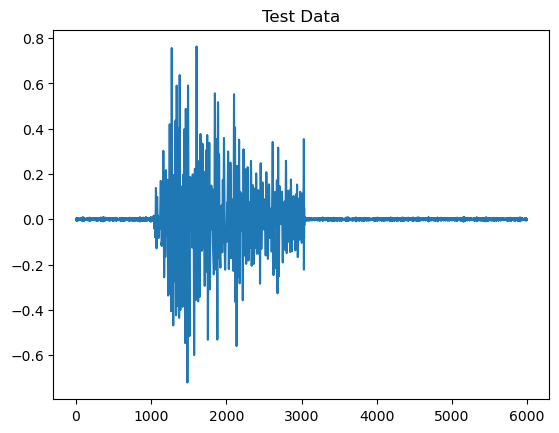

In [13]:
# model test by loading a piece of data from the dataset, and feed intot he prenn function

# index for the random data
idx = np.random.randint(NumSample)

# get the data
test_data = RESPONSE[idx, :].reshape(1, LenTS)

print('Test Data Shape:', test_data.shape)

# plot the test data
plt.figure()
plt.plot(test_data[0, :])
plt.title('Test Data')
plt.show()


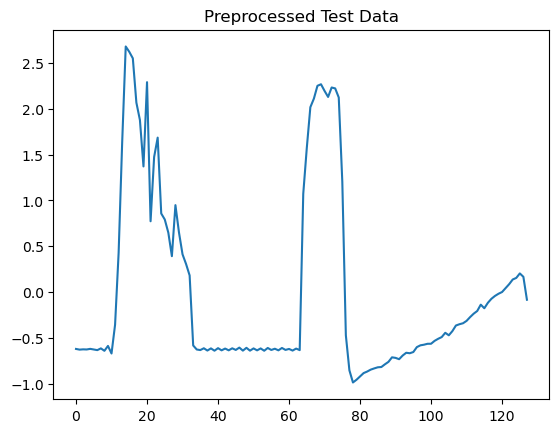

In [14]:
# preprocess
output_length = nn_in_len
test_data = prenn.prenn(test_data, dt, nperseg, output_length)

# print the preprocessed data
plt.figure()
plt.plot(test_data[0, :])
plt.title('Preprocessed Test Data')
plt.show()

In [15]:
test_data = test_data.reshape(1, nn_in_len, 1)

print('Preprocessed Test Data Shape:', test_data.shape)

# test the model
test_result = CNN_Model.predict(test_data)
print('Tensorflow Model Prediction:', test_result)

# parse the result to get the label
result_label = np.argmax(test_result)

print('Tensorflow Model Prediction:', result_label)

Preprocessed Test Data Shape: (1, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Tensorflow Model Prediction: [[6.8945906e-07 9.1122383e-01 8.6390570e-02 2.3849350e-03]]
Tensorflow Model Prediction: 1


### CONTROLLER
IN NATURE - THE BAYESIAN OPTIMIZATION FRAMEWORK FOR OPTIMIZATION AND CONTROLL

In [16]:
# the bayesian optimization algorithm, will be covered in the next section

## BAYESIAN OPTIMIZATION FRAMEWORK

### Helper Functions

In [17]:
# %pip install PyQt5
# %pip install colorama


In [18]:
# # use pop-up window for plots
# %matplotlib qt5 
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.animation import FuncAnimation
# # print control
# from colorama import init, Fore, Back, Style

In [19]:
# CONFIGURABLE PARAMETERS

## Hyperparameters
noise_lvl = 0.1
k_alpha = 1
k_lambda = 1

## Process Control
num_init_points = 15
num_iter = 20
tolerance = 1e-3
gap = np.inf

## Acquisition Function - UCB
ucb_beta = 1

## Acquisition Function - PI & EI
xi=0.01

## Bonus factor for evaluation
bonus_factor = 1.1

In [20]:
## Search Space
### parameter 1 - a
lb_a = para_a_lb
print('Lower Bound of para_a:', lb_a)
ub_a = para_a_ub
print('Upper Bound of para_a:', ub_a)
c_a = (ub_a + lb_a) / 2

### parameter 2 - b
lb_b = para_b_lb
print('Lower Bound of para_b:', lb_b)
ub_b = para_b_ub
print('Upper Bound of para_b:', ub_b)
c_b = (ub_b + lb_b) / 2
print(c_b)

Lower Bound of para_a: 8.422670419930013e-05
Upper Bound of para_a: 0.016845340839860026
Lower Bound of para_b: 2
Upper Bound of para_b: 10
6.0


### The Problem / System to Optimize

Triggering Mechanism： Triggering Parameters In; Evaluation Index Out

In [21]:
# THE OBJECTIVE FUNCTION
def objective_function(para_a, para_b):

    """ Function with unknown internals we wish to maximize.

    This function defines the process to evaluate how good the parameters are for the triggering sensing mechanism.

    INPUT:
    - para_a: the threshold for the activation, positive real number
    - para_b: activate_duration: the duration for the activation, positive integer >= 2 (as we know 1 is not error-prone in practice)

    OUTPUT:
    - evaluation value: F-beta score
    
    HYPERPARAMETERS:
    - beta: the value to balance the precision and recall to calculate F-beta score
    
    """
    
    # assistive variables
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    
    # go through the dataset
    for i in range(NumSample):
    # for i in range(10):  
        # trigger flag
        flg_trigger = 0
        
        # ground truth flag
        class_1h = np.zeros((1, num_type))
        flg_class = 0
        flg_interst = 0
        
        # get the response data
        signal = RESPONSE[i, :].reshape(1, LenTS)
        
        # get the triggering mechanism
        flg_trigger, trig_pos = trig.activation(signal, para_a, para_b)
        
        # print('Trigger Flag:', flg_trigger)
        
        # preprocess the signal for the CNN model to get the ground truth
        signal = prenn.prenn(signal, dt, nperseg, nn_in_len)
        
        signal = signal.reshape(1, nn_in_len, 1)

        # get the ground truth
        class_1h = CNN_Model.predict(signal, verbose=0)
        flag_class = np.argmax(class_1h)
        
        # get the ground truth
        if flag_class > 0:
            flg_interst = 1

        # get the confusion matrix - as the number of interested data is assumed to be small, we need to consider the ratio - only two classes - interested and non-interested
        if flg_trigger == 1 and flg_interst == 1:
            TP += 1
        elif flg_trigger == 1 and flg_interst == 0:
            FP += 1
        elif flg_trigger == 0 and flg_interst == 1:
            FN = -1 # no use, recall will be calculated in other way
        elif flg_trigger == 0 and flg_interst == 0:
            TN = -1 # no use, recall will be calculated in other way
        else:
            print('Error in Confusion Matrix Calculation')
    
    # recall = Precision_Model
    std_av = np.std(RESPONSE_AV[0, :])
    recall_input = np.array([std_av, para_a, para_b]).reshape(1, 3)
    recall = Recall_Model.predict(recall_input)
    recall = float(recall)
    
    if recall > 1:
        recall = 1
    if recall < 0:
        recall = 0
    
    # calculate precision
    precision = TP / (TP + FP)
            
    # calculate the F-beta score
    denominator = (beta**2) * precision + recall 
    if denominator == 0:
        F_beta = 0
    else:
        F_beta = (1 + beta**2) * precision * recall / denominator
    
    # if F_beta is NaN, return 0
    if np.isnan(F_beta):
        F_beta = 0
        return 0
    
    if precision > 0.9 and recall > 0.9:
        F_beta = F_beta * bonus_factor

    
    
    # print TP, FP, FN, TN as integer, Precision, Recall, F-beta as float number with 4 decimal places
    # print('para_a / para_b /TP / FP / FN / TN / Precision / Recall / F-beta:', para_a, para_b, TP, FP, FN, TN, f'{precision:.4f}', f'{recall:.4f}', f'{F_beta:.4f}')  
    # print('para_a / para_b ', para_a, para_b)  
    # print('TP / FP / FN / TN / Precision / Recall / F-beta:', TP, FP, FN, TN)  
    # print('Precision / Recall / F-beta:', f'{precision:.4f}', f'{recall:.4f}', f'{F_beta:.4f}')  
    print(f'para_a / para_b / TP / FP / FN / TN / Precision / Recall / F-beta: {para_a} {para_b} {int(TP)} {int(FP)} {int(FN)} {int(TN)} {precision:.4f} {recall:.4f} {F_beta:.4f}')

    return F_beta, TP, FP, FN, TN, precision, recall


In [22]:
# THE SURROGATE MODEL - Gaussian Process - Kernel Function
## Matern 2.5 as the kernel function
def kernel(p1, p2, matern_alpha = 1, matern_lambda = 1):
    # define the distance between two points p1 and p2
    d= np.linalg.norm(p1 - p2)
    k = matern_alpha * (1 + np.sqrt(5) * d / matern_lambda + 5 * d**2 / (3 * matern_lambda**2)) * np.exp(-np.sqrt(5) * d / matern_lambda)
    return k

## Mean and Variance of the Gaussian Process
def mean_var(x, D, K_alpha, k_lambda):
    # assume x is a variable of 1x1
    # calculate the mean and variance of the Gaussian Process
    x_dim = x.shape[1] # assume each colum is a dimension of x
    num_D = D.shape[0] # number of data points in D
    
    Ktt = np.zeros((num_D, num_D))
    for i in range(num_D):
        for j in range(num_D):
            Ktt[i, j] = kernel(D[i,:-1], D[j,:-1], K_alpha, k_lambda)
    Kttn = Ktt + np.eye(num_D) * noise_lvl
    IKttn = np.linalg.inv(Kttn)
    
    Kpt = np.zeros((1, num_D))
    for i in range(num_D):
        Kpt[0, i] = kernel(x, D[i,:-1], K_alpha, k_lambda)
    Ktp = Kpt.T
    Kpp = kernel(x, x, K_alpha, k_lambda)
    
    y = D[:,-1].reshape(-1,1)
    
    mean = Kpt @ IKttn @ y
    var = Kpp - Kpt @ IKttn @ Ktp
        
    return mean, var

In [23]:
# THE ACQUISITION FUNCTION - UPPER CONFIDENCE BOUND
def S(x, D):
    mean, var = mean_var(x, D, k_alpha, k_lambda)
    s = mean + ucb_beta * np.sqrt(var)
    return s

In [24]:
def norm_cdf(x):
    """
    standard normal cumulative distribution function
    
    """
    return 0.5 * (1 + np.math.erf(x / np.sqrt(2)))

In [25]:
def norm_pdf(x):
    """
    standard normal probability density function
    """
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x ** 2)

In [26]:
# THE ACQUISITION FUNCTION - PROBABILITY OF IMPROVEMENT
def S_PI(x, D, xi=0.01):
    f_best = np.max(D[:,-1])
    mean, var = mean_var(x, D, k_alpha, k_lambda)
    z = (mean - f_best - xi) / np.sqrt(var)
    s = norm_cdf(z)
    return s

In [27]:
# THE ACQUISITION FUNCTION - EXPECTATION OF IMPROVEMENT
def S_EI(x, D, xi=0.01):
    f_best = np.max(D[:,-1])
    mean, var = mean_var(x, D, k_alpha, k_lambda)
    z = (mean - f_best - xi) / np.sqrt(var)
    s = (mean - f_best - xi) * norm_cdf(z) + np.sqrt(var) * norm_pdf(z)
    return s

In [28]:
# THE OPTIMIZATION FUNCTION FOR THE ACQUISITION FUNCTION
def optimize_acquisition(D):
    # randomly search for the point with the highest acquisition function value
    num_search = 100
    max_s = -np.inf
    max_x = None
    cur_x = np.zeros((1,2))
    for i in range(num_search):
        cur_x[0,0] = np.random.uniform(lb_a, ub_a)
        cur_x[0,1] = np.random.uniform(lb_b, ub_b)
        cur_s = S(cur_x, D) # UCB
        # cur_s = S_PI(cur_x, D, xi) # PI
        # cur_s = S_EI(cur_x, D, xi) # EI
        if cur_s > max_s:
            max_s = cur_s
            max_x = cur_x.copy()
    return max_x

### The Optimization Process

In [29]:
# load data in STAGE II - D
D_Path = r"../01-PRE-DEPLOYMENT/05-PRE-OPTIMIZATION/D.npy"

D = np.load(D_Path)

stage_virtual_num = D.shape[0]

print('Number of Data Points in pre-optimization (D number):', stage_virtual_num)

DD_Path = r"../01-PRE-DEPLOYMENT/05-PRE-OPTIMIZATION/DD.npy"

DD = np.load(DD_Path)

print('Number of Data Points in pre-optimization (DD number):', DD.shape[0])

Number of Data Points in pre-optimization (D number): 45
Number of Data Points in pre-optimization (DD number): 45


In [30]:
max_val = np.max(D[:,2])
print('Initial Maximum Value:', max_val)

Initial Maximum Value: 1.0852809739058968


In [31]:
# REAL WORLD OPTIMIZATION ITERATIONS
for i in range(num_iter):
    
    update_flg = False
    
    tmp = np.zeros((1, 7)) # to store objective function value, TP, FP, FN, TN, Precision, Recall
    
    # (1) use the surrogate model to approach the posterior distribution of the objective function, modeled by Gaussian Process which can be characterized by the mean function and the covariance function
    
    ## mean, var = mean_var(x, D, 1, 1)
    
    # (2) determine the next point to evaluate using the acquisition function S(D)
    x_eval = optimize_acquisition(D)
    
    # (3) evaluate the objective function at the next point
    tmp = objective_function(x_eval[0,0], x_eval[0,1])
    
    f_eval = tmp[0]
    
    # (4) update the dataset D
    newpoint = np.zeros((1,3))
    newpoint[0,0] = x_eval[0,0]
    newpoint[0,1] = x_eval[0,1]
    newpoint[0,2] = f_eval
    D = np.vstack((D, newpoint))

    newpoint_d = np.zeros((1,9))
    newpoint_d[0,0] = x_eval[0,0]
    newpoint_d[0,1] = x_eval[0,1]
    newpoint_d[0,2:] = tmp
    DD = np.vstack((DD, newpoint_d))
    
    # # (5) check the stopping criterion
    # gap = np.abs(D[-1, -1] - D[-2, -1])
    # if gap < tolerance:
    #     break
    
    # (5) update the global best value
    if f_eval > max_val:
        max_val = f_eval
        max_x = x_eval
        update_flg = True
    
    # (6) print the progress
    if (update_flg == True):
        print('BO Iteration:', i+1,'/', num_iter, 'Best Value Updated:', max_val, 'at', max_x)
    else:
        print('BO Iteration:', i+1,'/', num_iter)
    
    # (7) reset the flag
    update_flg = False
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
para_a / para_b / TP / FP / FN / TN / Precision / Recall / F-beta: 0.014621190219126345 2.8733829047122263 99 1 -1 -1 0.9900 0.9246 1.0339
BO Iteration: 1 / 20


C:\Users\cswof\AppData\Local\Temp\ipykernel_34424\722499414.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  recall = float(recall)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
para_a / para_b / TP / FP / FN / TN / Precision / Recall / F-beta: 0.006595805262892647 2.721855379770587 122 74 0 -1 0.6224 0.9505 0.8413
BO Iteration: 2 / 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
para_a / para_b / TP / FP / FN / TN / Precision / Recall / F-beta: 0.009842200654094272 2.8668280403823987 110 5 -1 -1 0.9565 0.9394 1.0379
BO Iteration: 3 / 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
para_a / para_b / TP / FP / FN / TN / Precision / Recall / F-beta: 0.003386889772038488 2.9888709959655673 122 178 0 0 0.4067 0.9583 0.7184
BO Iteration: 4 / 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
para_a / para_b / TP / FP / FN / TN / Precision / Recall / F-beta: 0.01677787011610551 2.454821597994793 99 1 -1 -1 0.9900 0.9212 1.0309
BO Iteration: 5 / 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
para_a / para_b / TP / FP / FN / TN / Precision / Recall / F-beta: 0.01168930556346519 2.3924293509953465 103 2 -1 -1 0.9810 0.9373 1.0424
BO Iteration: 6 / 20
1/1 ━━━━━━

In [32]:
# number of points in D and DD
print('Number of Data Points in D:', D.shape[0])
print(D.shape[0])

print('Number of Data Points in DD:', DD.shape[0])
print(DD.shape[0])

Number of Data Points in D: 65
65
Number of Data Points in DD: 65
65


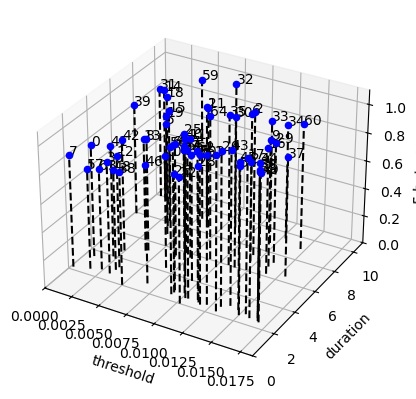

In [33]:
# Visualization
# stem plot

# Assuming D is already defined and contains your data
# D[:, 0] -> threshold
# D[:, 1] -> duration
# D[:, 2] -> F-beta score

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('threshold')
ax.set_ylabel('duration')
ax.set_zlabel('F-beta score')
ax.set_xlim(0, 1.1*ub_a)
ax.set_ylim(0, 1.1*ub_b)
ax.set_zlim(0, bonus_factor)

# Create stem plot
for i in range(D.shape[0]):
    x = D[i, 0]
    y = D[i, 1]
    z = D[i, 2]
    ax.plot([x, x], [y, y], [0, z], 'k--')
    ax.scatter(x, y, z, c='b', marker='o')
    ax.text(x, y, z, str(i), color='black')

plt.show()


In [34]:
# print the final value
print(D[-1, -1])

# print the max value
print(np.max(D[:, -1]))

# print the argmax
print(D[np.argmax(D[:, -1]), :-1])

# print the row index of the max value
print(np.argmax(D[:, -1]))

1.027850914455125
1.0852809739058968
[0.01380569 2.99870086]
43


In [35]:
# save lb_a, ub_a, lb_b, ub_b, noise_lvl, k_alpha, k_lambda, num_init_points, num_iter, tolerance, ucb_beta
np.save('config.npy', np.array([lb_a, ub_a, lb_b, ub_b, noise_lvl, k_alpha, k_lambda, num_init_points, num_iter, tolerance, ucb_beta]))

# save D to a file
np.save('D.npy', D)

# save DD to a file
np.save('DD.npy', DD)

## POST PROCESSING

In [36]:
# COMMON
import numpy as np
import sys
import os
import random
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Triggering Mechanism
import triggering as trig

# Signal Processing
from scipy import signal  # for signal processing
from scipy.signal import hilbert  # for signal processing
import prenn # for deep learning

# AI
import keras

import tensorflow as tf # for deep learning
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import TensorBoard # for visualization

import onnxruntime as ort # for onnx runtime

# Visualization
# %matplotlib qt5
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

In [37]:
# load data in STAGE II - D
DV_Path = r"../01-PRE-DEPLOYMENT/05-PRE-OPTIMIZATION/D.npy"

DV = np.load(DV_Path)

stage_virtual_num = DV.shape[0]

print('Number of Data Points in Virtual Environment:', stage_virtual_num)

Number of Data Points in Virtual Environment: 45


In [38]:
DD = np.load('DD.npy')

In [39]:
import plotly.graph_objects as go
import numpy as np

# Load the data
D = np.load('D.npy')

# Get the number of rows in D
num_D = D.shape[0]

# Define stage_virtual_num to determine the cutoff for red vs. blue
stage_virtual_num = 45  # Set your desired value for stage_virtual_num, ensure it's an integer

# Split the data into two parts
thresholds = D[:, 0]
durations = D[:, 1]
F_beta = D[:, 2]

# Create a 3D scatter plot
fig = go.Figure()

# Use a red color scale for the first stage_virtual_num data points
red_colorscale = [
    [0.0, 'rgb(255, 200, 200)'],  # Light red
    [1.0, 'rgb(139, 0, 0)']       # Dark red
]

# Add red-colored points for the first stage_virtual_num data
fig.add_trace(go.Scatter3d(
    x=thresholds[:stage_virtual_num],
    y=durations[:stage_virtual_num],
    z=F_beta[:stage_virtual_num],
    mode='markers',
    marker=dict(size=5, color=F_beta[:stage_virtual_num], colorscale=red_colorscale, showscale=True,
                colorbar=dict(title="F-beta", len=0.5, x=1.15)),  # Move color bar to the right
    name='Virtual Environment Optimization'
))

# Use a blue color scale for the remaining data points
blue_colorscale = [
    [0.0, 'rgb(200, 200, 255)'],  # Light blue
    [1.0, 'rgb(0, 0, 139)']       # Dark blue
]

# Add blue-colored points for the remaining data
fig.add_trace(go.Scatter3d(
    x=thresholds[stage_virtual_num:],
    y=durations[stage_virtual_num:],
    z=F_beta[stage_virtual_num:],
    mode='markers',
    marker=dict(size=5, color=F_beta[stage_virtual_num:], colorscale=blue_colorscale, showscale=True,
                colorbar=dict(title="F-beta", len=0.5, x=1.25)),  # Move this color bar further to the right
    name='Real World Optimization'
))

# Set axis labels, font, axis limits, and ranges
fig.update_layout(
    scene=dict(
        xaxis=dict(title='Threshold', titlefont=dict(family='Times New Roman'), range=[0, 0.016]),  # Set x-axis range
        yaxis=dict(title='Duration', titlefont=dict(family='Times New Roman'), range=[0, 12]),  # Set y-axis range
        zaxis=dict(title='F-beta', titlefont=dict(family='Times New Roman'), range=[0.5, 1.2]),  # Set z-axis range
        camera=dict(eye=dict(x=1.25, y=1.25, z=1.25), projection=dict(type="perspective"))  # Use perspective projection
    ),
    # Set global font to Times New Roman
    font=dict(family='Times New Roman', size=12),  # Apply to all text
    autosize=False,
    width=900,  # Set the width
    height=800,  # Set the height
)

# Show the plot
fig.show()


In [40]:
# Save the figure as a static image with the name "virtual.png"
# fig.write_image("real.png")

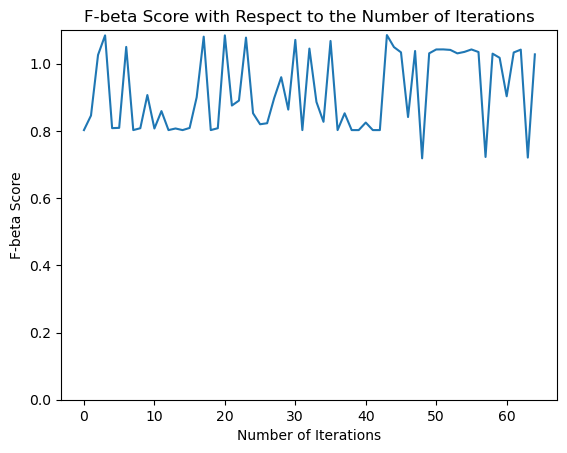

In [41]:
bonus_factor = 1.1
# plot F-beta score with respect to the number of iterations
plt.plot(D[:, 2])
plt.xlabel('Number of Iterations')
plt.ylabel('F-beta Score')
plt.title('F-beta Score with Respect to the Number of Iterations')
# y starts from 0
plt.ylim(0, bonus_factor)
plt.show()

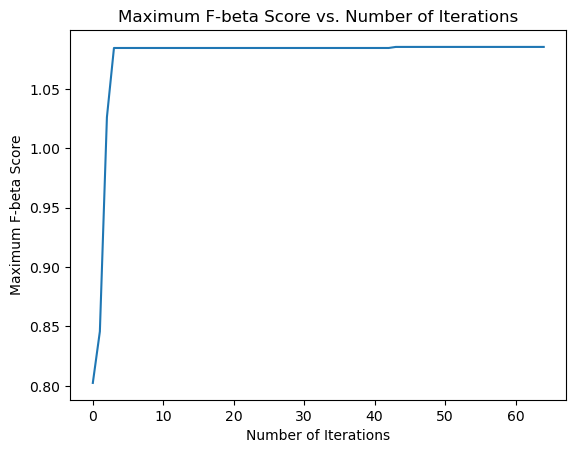

In [42]:
# track the largest F-beta score going through the iterations
max_F_beta = np.zeros(D.shape[0])
for i in range(D.shape[0]):
    max_F_beta[i] = np.max(D[:i+1, 2])

# plot the max_F_beta, the horizontal axis is the number of iterations, the vertical axis is the maximum F-beta score
plt.plot(max_F_beta)
plt.xlabel('Number of Iterations')
plt.ylabel('Maximum F-beta Score')
plt.title('Maximum F-beta Score vs. Number of Iterations')
plt.show()

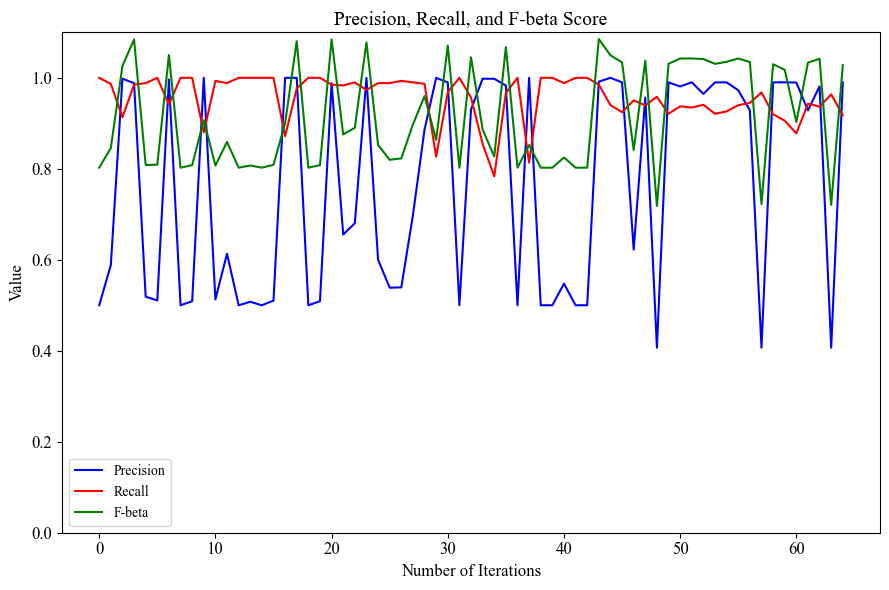

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming DD is a NumPy array containing the data
iterations = np.arange(DD.shape[0])
precision = DD[:, -2]
recall = DD[:, -1]
F_beta = DD[:, 2]

# Set the figure size (9x6 inches roughly corresponds to 900x600 pixels)
plt.figure(figsize=(9, 6))

# Plot each line with specified color and line width
plt.plot(iterations, precision, label='Precision', color='blue', linewidth=1.5)
plt.plot(iterations, recall, label='Recall', color='red', linewidth=1.5)
plt.plot(iterations, F_beta, label='F-beta', color='green', linewidth=1.5)

# Set axis labels and title, using Times New Roman font
plt.xlabel('Number of Iterations', fontname='Times New Roman', fontsize=12)
plt.ylabel('Value', fontname='Times New Roman', fontsize=12)
plt.title('Precision, Recall, and F-beta Score', fontname='Times New Roman', fontsize=14)

# Set y-axis limits from 0 to bonus_factor
plt.ylim(0, bonus_factor)

# Set tick labels to Times New Roman font
plt.xticks(fontname='Times New Roman', fontsize=12)
plt.yticks(fontname='Times New Roman', fontsize=12)

# Add legend to the plot and set its font to Times New Roman
plt.legend(prop={'family': 'Times New Roman'})

# Adjust the layout to prevent clipping of labels and titles
plt.tight_layout()

# Save the figure as a static image file
plt.savefig('history.png')

# Display the plot
plt.show()

max f-beta, recall, precision
1.0852809739058968
0.985
0.9916107382550335


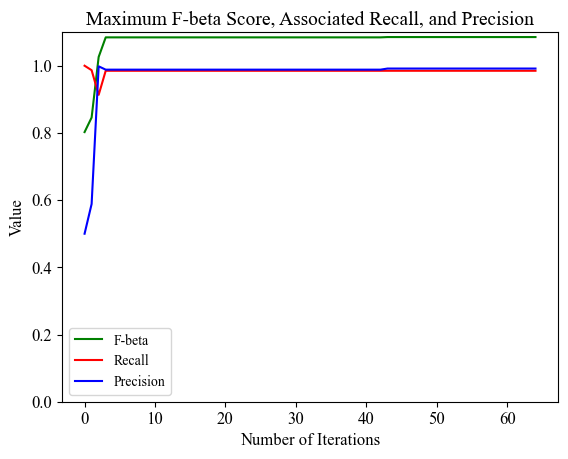

In [44]:
# track the largest F-beta score going through the iterations and record associated recall and precision
iterations = np.arange(DD.shape[0])
max_F_beta = np.zeros(DD.shape[0])
max_associated_recall = np.zeros(DD.shape[0])
max_associated_precision = np.zeros(DD.shape[0])
for i in range(DD.shape[0]):
    max_F_beta[i] = np.max(DD[:i+1, 2])
    max_index = np.argmax(DD[:i+1, 2])
    max_associated_recall[i] = DD[max_index, -1]
    max_associated_precision[i] = DD[max_index, -2]

# print the max_F_beta, recall, and precision
print("max f-beta, recall, precision")
print(max_F_beta[-1])
print(max_associated_recall[-1])
print(max_associated_precision[-1])

# plot the max_F_beta, the horizontal axis is the number of iterations, the vertical axis is the maximum F-beta score, and associated recall and precision

plt.plot(iterations, max_F_beta, label='F-beta', color='green', linewidth=1.5)
plt.plot(iterations, max_associated_recall, label='Recall', color='red', linewidth=1.5)
plt.plot(iterations, max_associated_precision, label='Precision', color='blue', linewidth=1.5)

plt.xlabel('Number of Iterations', fontname='Times New Roman', fontsize=12)
plt.ylabel('Value', fontname='Times New Roman', fontsize=12)
plt.title('Maximum F-beta Score, Associated Recall, and Precision', fontname='Times New Roman', fontsize=14)

# from 0 to bonus_factor
plt.ylim(0, bonus_factor)

# Set tick labels to Times New Roman font
plt.xticks(fontname='Times New Roman', fontsize=12)
plt.yticks(fontname='Times New Roman', fontsize=12)

# legend
plt.legend(prop={'family': 'Times New Roman'})

plt.show()
